In [224]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import functools
import numpy as np
from scipy.spatial.transform import Rotation as R

In [183]:
data = pd.read_csv("test_acc_data.csv")

In [184]:
data

,offset,acc_x,acc_y,acc_z
0,2021-06-15 16:49:37.486,-7.342716,-6.395549,2.979706
1,2021-06-15 16:49:37.366,-7.507906,-6.481473,2.959036
2,2021-06-15 16:49:37.356,-7.219462,-6.454059,2.662200
3,2021-06-15 16:49:37.256,-7.239897,-6.540169,2.533991
4,2021-06-15 16:49:37.157,-7.290423,-6.398326,2.829583
...,...,...,...,...
1150,2021-06-15 16:47:38.185,-8.674248,-4.906263,1.376525
1151,2021-06-15 16:47:38.085,-8.552615,-4.729685,1.341283
1152,2021-06-15 16:47:37.984,-8.588931,-5.027697,1.489017
1153,2021-06-15 16:47:37.874,-8.823305,-5.102883,1.443593


In [185]:
data.describe()

,acc_x,acc_y,acc_z
count,1155.000000,1155.000000,1155.000000
mean,-8.435743,-4.964285,1.684990
std,0.491553,0.730012,0.877896
min,-10.378469,-7.034986,-2.051115
25%,-8.767544,-5.387640,1.246561
50%,-8.397971,-5.084617,1.608047
75%,-8.181384,-4.455072,2.063193
max,-6.754988,-2.792250,4.926768


<AxesSubplot:>

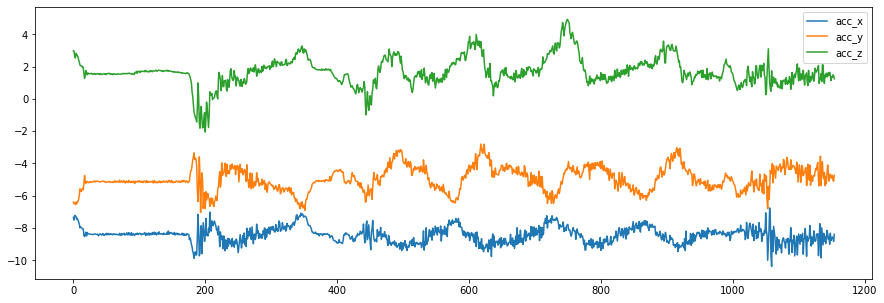

In [186]:
data.plot(figsize=(15,5))


In [187]:
data[30:160]['acc_z'].describe()

count    130.000000
mean       1.629273
std        0.086709
min        1.497975
25%        1.548894
50%        1.608112
75%        1.711846
max        1.782344
Name: acc_z, dtype: float64

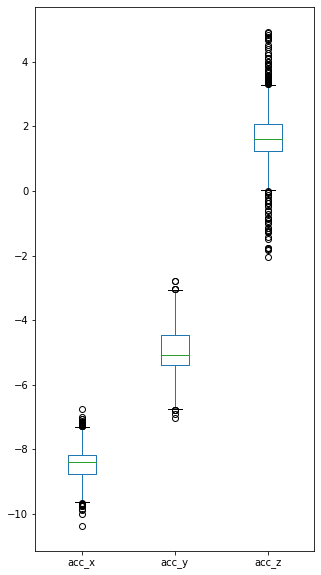

In [188]:
ax = data.plot(kind='box', figsize=(5,10))


In [189]:
data_z = data['acc_z'].copy()

In [190]:
data_trim = data_z.rolling(100).mean()
data_trim.describe()

count    1056.000000
mean        1.692975
std         0.494438
min         0.518696
25%         1.388634
50%         1.658250
75%         2.098044
max         2.744968
Name: acc_z, dtype: float64

<AxesSubplot:>

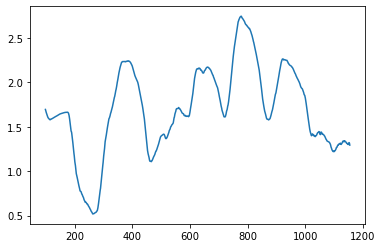

In [191]:
data_trim.plot()

In [192]:
data_trim = data_z.rolling(100).apply(lambda w: stats.trim_mean(w, 0.1))
data_trim.describe()

count    1056.000000
mean        1.687668
std         0.446054
min         0.638890
25%         1.397932
50%         1.648294
75%         2.059472
max         2.663624
Name: acc_z, dtype: float64

<AxesSubplot:>

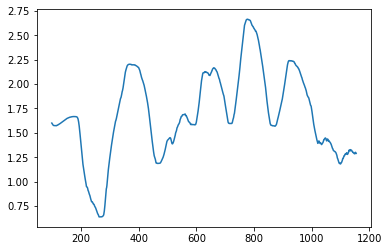

In [193]:
data_trim.plot()

In [194]:
data_trim = data_z.rolling(100).median()
data_trim.describe()

count    1056.000000
mean        1.656588
std         0.386233
min         0.911567
25%         1.386127
50%         1.602225
75%         1.932952
max         2.574076
Name: acc_z, dtype: float64

<AxesSubplot:>

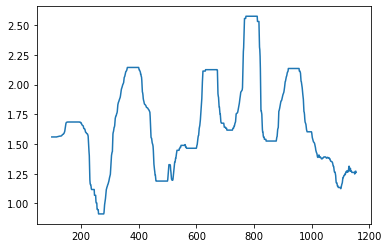

In [195]:
data_trim.plot()

In [196]:
def cut_anomalies(df: pd.DataFrame) -> pd.DataFrame:
    data_roll = df.rolling(100).median()
    return data_roll

In [197]:
def get_basis(df: pd.DataFrame) -> pd.DataFrame:
    data_roll = cut_anomalies(df)
    acc_vec = []
    for column in data_roll:
        acc_vec.append(data_roll[column].median())
    return acc_vec

In [198]:
def find_g(df: pd.DataFrame, *args, **kwargs) -> float:
    #Takes accelerometer data as input and outputs gravity of Earth (which should be close to 9.8m/s^2)
    acc_vec = get_basis(df)
    acc_vec = [i**2 for i in acc_vec]
    g = np.sqrt(sum(acc_vec))
    return g

In [199]:
def find_angle(df: pd.DataFrame, g: float, *args, **kwargs) -> R:
    #Takes accelerometer data and estimated gravity of Earth and outputs Rotation object from scipy.spatial.transform, which aligns OZ axis
    vec = get_basis(df)
    basis_vec = [1.0, 1.0, g]
    vec = np.reshape(vec, (1,3))
    basis_vec = np.reshape(basis_vec, (1,3))
    r = R.align_vectors(vec, basis_vec)
    return r

In [225]:
def main(input_path: str, output_path: str, image_path: str = None):
    #Takes path to accelerometer data in .csv format and writes OZ aligned data in output_path in .csv format. If image_path is not None, outputs image data to specified path in .png format
    df = pd.read_csv(input_path)
    vectors = data.iloc[:, 1:].values.tolist()
    g = find_g(df)
    angle = find_angle(df, g)
    vecs_aligned = r[0].apply(vectors)
    df_aligned = pd.DataFrame(vecs_aligned, columns=['acc_x', 'acc_y', 'acc_z'])
    df_aligned['acc_z'] = df_aligned['acc_z'].abs()
    df_aligned['offset'] = df['offset'].copy()
    df_aligned.to_csv(output_path)
    if(image_path is not None):
        df.plot(figsize=(15,5))
        plt.savefig(image_path)


In [200]:
vectors = data.iloc[:, 1:].values.tolist()

In [207]:
find_g(data)

9.910197945268393

In [208]:
get_basis(data)

[-8.396409112913862, -5.01450033425462, 1.6022246161943876]

In [202]:
r = find_angle(data, g)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  import sys


In [211]:
rotated_vecs = r[0].apply(vectors)

In [220]:
df = pd.DataFrame(rotated_vecs, columns=['acc_x', 'acc_y', 'acc_z'])
df['acc_z'] = df['acc_z'].abs()

<AxesSubplot:>

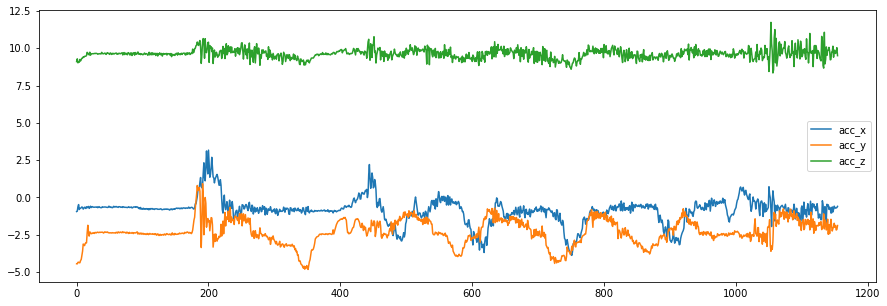

In [221]:
df.plot(figsize=(15,5))

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  import sys


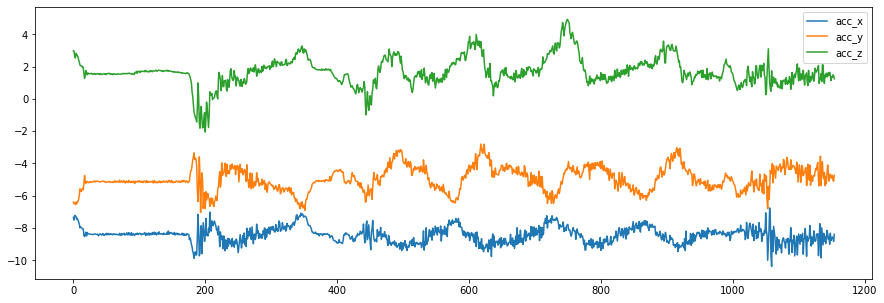

In [226]:
main('test_acc_data.csv', 'rotated.csv', 'rotated.png')